In [27]:
# Step 1: Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
# Step 2: Load the dataset
df = pd.read_csv("tmp.csv")

# Display first few rows
print(df.head())

# Check data info
print(df.info())


         DATE  TEMPERATURE
0  31-01-1901     -0.39375
1  28-02-1901      0.16875
2  31-03-1901      7.13125
3  30-04-1901     10.65000
4  31-05-1901     14.51250
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1428 entries, 0 to 1427
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   DATE         1428 non-null   object 
 1   TEMPERATURE  1428 non-null   float64
dtypes: float64(1), object(1)
memory usage: 22.4+ KB
None


In [28]:
def preprocess_temperature_data(df, sequence_length=12, test_size=0.2):
    # 1️⃣ Convert date column
    df['DATE'] = pd.to_datetime(df['DATE'], format="%d-%m-%Y")
    
    # 2️⃣ Sort by date (ascending)
    df = df.sort_values('DATE')
    
    # 3️⃣ Handle missing values (if any)
    df['TEMPERATURE'] = df['TEMPERATURE'].interpolate()  # linear interpolation
    
    # 4️⃣ Scale temperature to range [0,1] for RNN stability
    scaler = MinMaxScaler(feature_range=(0, 1))
    df['SCALED_TEMP'] = scaler.fit_transform(df[['TEMPERATURE']])
    
    # 5️⃣ Convert temperature data to sequences
    data = df['SCALED_TEMP'].values
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i + sequence_length])
        y.append(data[i + sequence_length])
    
    X = np.array(X)
    y = np.array(y)
    
    # 6️⃣ Train-test split
    split_idx = int(len(X) * (1 - test_size))
    X_train, X_test = X[:split_idx], X[split_idx:]
    y_train, y_test = y[:split_idx], y[split_idx:]
    
    print(f"✅ Data preprocessed successfully!")
    print(f"Total samples: {len(X)} | Train: {len(X_train)} | Test: {len(X_test)}")
    
    return X_train, X_test, y_train, y_test, scaler, df


✅ Data preprocessed successfully!
Total samples: 1416 | Train: 1132 | Test: 284


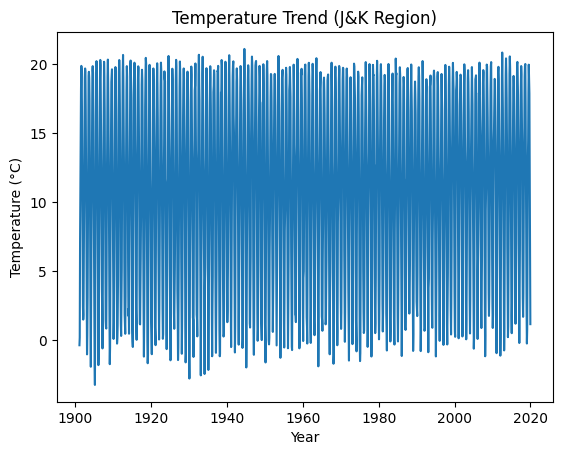

In [29]:
# Call the function
X_train, X_test, y_train, y_test, scaler, df_processed = preprocess_temperature_data(df)

# Optional: visualize
plt.plot(df_processed['DATE'], df_processed['TEMPERATURE'])
plt.title("Temperature Trend (J&K Region)")
plt.xlabel("Year")
plt.ylabel("Temperature (°C)")
plt.show()


In [30]:
df_processed

,DATE,TEMPERATURE,SCALED_TEMP
0,1901-01-31,-0.39375,0.118084
1,1901-02-28,0.16875,0.141137
2,1901-03-31,7.13125,0.426486
3,1901-04-30,10.65000,0.570697
4,1901-05-31,14.51250,0.728996
...,...,...,...
1423,2019-08-31,19.00625,0.913166
1424,2019-09-30,17.88125,0.867059
1425,2019-10-31,12.35000,0.640369
1426,2019-11-30,6.74375,0.410605


In [31]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

def train_lstm_model(X_train, y_train, X_test, y_test, epochs=100, batch_size=16):
    """
    Trains an enhanced LSTM model on time-series temperature data.

    Improvements:
    - Uses Bidirectional LSTM for richer context understanding
    - Adds Dropout to prevent overfitting
    - Includes callbacks (EarlyStopping, ReduceLROnPlateau, ModelCheckpoint)
    - Adaptive learning rate scheduling for better convergence
    """

    # ✅ 1️⃣ Reshape input to [samples, timesteps, features]
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

    # ✅ 2️⃣ Build the model
    model = Sequential([
        Bidirectional(LSTM(128, return_sequences=True, activation='tanh'), input_shape=(X_train.shape[1], 1)),
        Dropout(0.3),
        LSTM(64, return_sequences=False, activation='tanh'),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dense(1)  # Output layer
    ])

    # ✅ 3️⃣ Compile the model
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

    # ✅ 4️⃣ Define callbacks
    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=5, min_lr=1e-5, verbose=1)
    checkpoint = ModelCheckpoint('best_lstm_model.keras', monitor='val_loss', save_best_only=True, verbose=1)

    # ✅ 5️⃣ Train the model
    history = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[early_stop, reduce_lr, checkpoint],
        verbose=1
    )

    # ✅ 6️⃣ Evaluate the model
    loss, mae = model.evaluate(X_test, y_test, verbose=0)
    print(f"✅ Model trained successfully! Test Loss: {loss:.5f}, MAE: {mae:.5f}")

    # ✅ Return model and history
    return model, history


In [32]:
model, history = train_lstm_model(X_train, y_train, X_test, y_test, epochs=100, batch_size=16)


Epoch 1/100


c:\Users\user\Desktop\deep\venv_tf\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


70/71 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.1452 - mae: 0.3207
Epoch 1: val_loss improved from None to 0.06559, saving model to best_lstm_model.keras
71/71 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.1054 - mae: 0.2797 - val_loss: 0.0656 - val_mae: 0.2249 - learning_rate: 0.0010
Epoch 2/100
70/71 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0398 - mae: 0.1643
Epoch 2: val_loss improved from 0.06559 to 0.00416, saving model to best_lstm_model.keras
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0253 - mae: 0.1252 - val_loss: 0.0042 - val_mae: 0.0493 - learning_rate: 0.0010
Epoch 3/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0074 - mae: 0.0667
Epoch 3: val_loss improved from 0.00416 to 0.00338, saving model to best_lstm_model.keras
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0075 - mae: 0.0675 - val_loss: 0.0034 - val_mae: 0.0440 - learning_rate: 0.0010
Epoch 4/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0067 - mae: 0.0651
Epoch 4: val_loss did not impro

In [33]:
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
test_loss = model.evaluate(X_test, y_test)
print("Test MSE:", test_loss)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0019 - mae: 0.0334
Test MSE: [0.0019134245812892914, 0.033417146652936935]


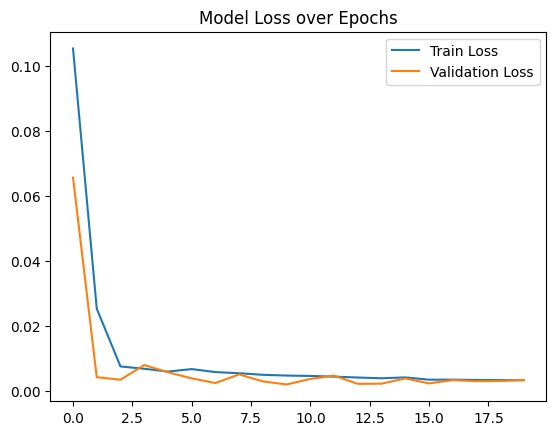

In [39]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title("Model Loss over Epochs")
plt.show()


In [40]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# 1️⃣ Predict on test data
y_pred = model.predict(X_test)

# 2️⃣ Calculate metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"📈 MAE:  {mae:.4f}")
print(f"📉 MSE:  {mse:.4f}")
print(f"✅ RMSE: {rmse:.4f}")
print(f"⭐ R² Score: {r2:.4f}")


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
📈 MAE:  0.0334
📉 MSE:  0.0019
✅ RMSE: 0.0437
⭐ R² Score: 0.9760


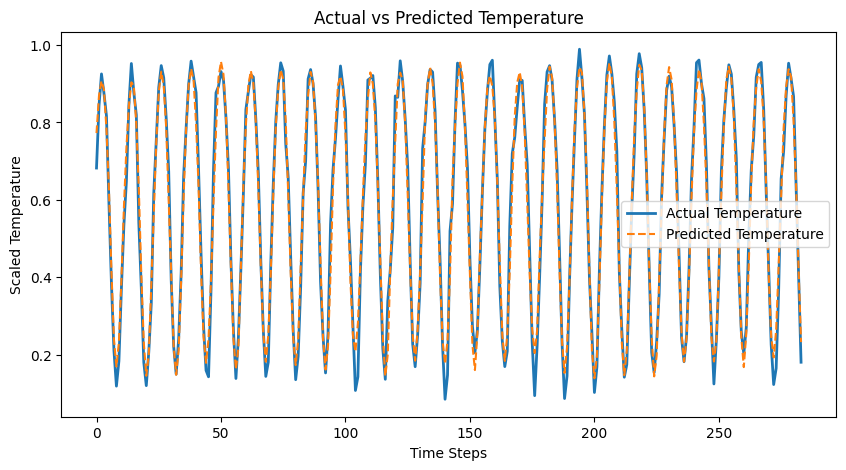

In [41]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(y_test, label='Actual Temperature', linewidth=2)
plt.plot(y_pred, label='Predicted Temperature', linestyle='--')
plt.title("Actual vs Predicted Temperature")
plt.xlabel("Time Steps")
plt.ylabel("Scaled Temperature")
plt.legend()
plt.show()


In [42]:
import numpy as np

def predict_next_temperature(model, scaler, recent_temps, sequence_length=10):
    """
    Predicts the next temperature based on the last 'sequence_length' values.
    """

    # Convert input list to numpy array
    recent_temps = np.array(recent_temps).reshape(-1, 1)

    # Scale input using the same scaler used during training
    scaled_input = scaler.transform(recent_temps)

    # Make sure length matches model's expected sequence length
    if len(scaled_input) < sequence_length:
        # pad with zeros if input is shorter
        padding = np.zeros((sequence_length - len(scaled_input), 1))
        scaled_input = np.vstack((padding, scaled_input))

    # Reshape for LSTM input: [samples, timesteps, features]
    X_input = scaled_input.reshape(1, sequence_length, 1)

    # Predict
    predicted_scaled = model.predict(X_input)
    predicted_temp = scaler.inverse_transform(predicted_scaled)

    return predicted_temp[0][0]


# 🔹 Example usage:
print("Enter last 10 temperature values:")
user_input = [float(x) for x in input("Values (comma separated): ").split(",")]

predicted = predict_next_temperature(model, scaler, user_input)
print(f"🌡️ Predicted Next Temperature: {predicted:.2f} °C")


Enter last 10 temperature values:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
🌡️ Predicted Next Temperature: 6.26 °C


c:\Users\user\Desktop\deep\venv_tf\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [37]:
# y_test
print(y_test[:10])

[0.68237705 0.84298156 0.92546107 0.87525615 0.81711066 0.59118852
 0.38396516 0.21157787 0.11910861 0.18391393]


In [38]:
y_pred[:10]

array([[0.77270573],
       [0.8690595 ],
       [0.9072238 ],
       [0.8852008 ],
       [0.78226286],
       [0.6265084 ],
       [0.41490713],
       [0.24021733],
       [0.1699743 ],
       [0.23219302]], dtype=float32)

In [43]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

# Predict test set
y_pred = model.predict(X_test)

# Calculate metrics
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f"✅ R² Score: {r2:.4f}")
print(f"✅ Approx. Accuracy: {r2 * 100:.2f}%")
print(f"✅ MAE: {mae:.4f}")
print(f"✅ RMSE: {rmse:.4f}")


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
✅ R² Score: 0.9760
✅ Approx. Accuracy: 97.60%
✅ MAE: 0.0334
✅ RMSE: 0.0437
